In [1]:
# Import necessary librariesimport pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import os
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

In [2]:
# List of file names with their respective park names
file_park_mapping = {
    'Central_Park_Reviews.csv': 'Central Park',
    'Eco_Tourism_Park_Reviews.csv': 'Eco Tourism Park',
    'Elliot_Park_Reviews.csv': 'Elliot Park',
    'Maidan_Reviews.csv': 'Maidan',
    'Millenium_Park_Reviews.csv': 'Millenium Park',
    'Nature_Park_Reviews.csv': 'Nature Park',
    'Nicco_Park_Reviews.csv': 'Nicco Park',
    'Princep_Ghat_Park_Reviews.csv': 'Princep Ghat Park',
    'Rabindra_Sarobar_Reviews.csv': 'Rabindra Sarobar',
    'Science_City_Reviews.csv': 'Science City'
}

# Initialize an empty DataFrame to store aggregated data
all_reviews = pd.DataFrame()

# Iterate through each file, add the 'Park' column, and concatenate data
for file_name, park_name in file_park_mapping.items():
    file_path = os.path.join('C:/Users/aryan/Documents/NLP/Review_Data', file_name)  # Update path_to_your_directory with your actual directory path
    df = pd.read_csv(file_path,encoding='latin1')
    df['Park'] = park_name
    all_reviews = pd.concat([all_reviews, df])

# Reset index
all_reviews.reset_index(drop=True, inplace=True)

# Write aggregated data to a single CSV file
all_reviews.to_csv('C:/Users/aryan/Documents/NLP/Review_Data/Reviews.csv', index=False)  # Update path_to_your_directory with your desired directory path

In [3]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv("C:/Users/aryan/Documents/NLP/Review_Data/Reviews.csv")

In [4]:
# Display the first few rows of the DataFrame
df.head()

,Date,Ratings,Review,Park
0,Aug 2019,4.0,Best for photo shoots and love the rose garden...,Central Park
1,Dec 2019,5.0,Another attraction in the Central Park is its ...,Central Park
2,Apr 2019,4.0,There is enough greenery to bring people and a...,Central Park
3,Jan 2019,3.0,"If you are in Salt Lake City of Kolkata, you m...",Central Park
4,Feb 2019,3.0,Not a good place to just hang out with friends...,Central Park


In [5]:
# Print information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3243 non-null   object 
 1   Ratings  3243 non-null   float64
 2   Review   3243 non-null   object 
 3   Park     3243 non-null   object 
dtypes: float64(1), object(3)
memory usage: 101.5+ KB


In [6]:
# Generate descriptive statistics of the DataFrame
df.describe()

,Ratings
count,3243.000000
mean,4.469935
std,0.831189
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
# Check for missing values in each column and calculate the sum
missing_values = all_reviews.isna().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Date       0
Ratings    0
Review     0
Park       0
dtype: int64


In [8]:
# Print the shape of the DataFrame
df.shape

(3243, 4)

In [9]:
#Preprocessing

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc) #remove any characters that are not alphanumeric or whitespace
    doc = doc.lower() #lowercase
    doc = doc.strip() #Removes leading and trailing whitespaces
    tokens = nltk.word_tokenize(doc) #Tokenizes the document into individual words
    filtered_tokens = [token for token in tokens if token not in stop_words] #Filters out stopwords
    doc = ' '.join(filtered_tokens) #Reconstructs the document from the filtered tokens by joining them back into a single string separated by spaces
    return doc

normalize_corpus = np.vectorize(normalize_document) #Vectorizes the normalize_document function

norm_corpus = normalize_corpus(list(df['Review'])) # applying function to dataframe, producing a normalized corpus of documents
norm_corpus

array(['best photo shoots love rose gardenthe park surrounded lush green trees flowers small pond give attraction parkthere number benches sitting along small food canteen sells various fast foodthe attraction park well shaped chinese pagoda shadeentry fee inr 40 camera fee inr 30 big car parking area',
       'another attraction central park beautiful butterfly garden home several species colorful butterflies',
       'enough greenery bring people lot couplesnice place photos maintained well',
       ...,
       'mood picnic kids science city place kids knowledge scientific facts time machine ride enjoy science city also got one best auditoriums kolkata nothing else soak sun enjoy',
       'science city one favourite places kolkatait basically science technology museum difference science museums science city science city makes interesting number games experiments performed makes science interesting subject borethus recomend people age groups especially childrento visit science city ex

In [10]:
#convert a collection of text documents (norm_corpus) into a matrix of token counts

cv = CountVectorizer(ngram_range=(1, 2), min_df=20, max_df=0.8) #both single words and pairs of consecutive words. Tokens that occur in fewer than 20 documents will be ignored. Tokens that occur in more than 80% of the documents will be ignored.
cv_matrix = cv.fit_transform(norm_corpus) #transforms the corpus into a document-term matrix. The value at the intersection of a row and column represents the count of how many times that word or n-gram appears in the corresponding document.
cv_matrix.shape #(n_documents, n_features). n_documents represents the number of documents in the corpus, and n_features represents the number of unique words and n-grams in the vocabulary.

(3243, 828)

# Clustering

In [11]:
# Initialize an empty list to store within-cluster sum of squares


# Iterate through different numbers of clusters
css = [] 
for i in range(2, 8): #iteration
    kmeans = KMeans(n_clusters=i, max_iter=100, n_init=10, random_state=42).fit(cv_matrix) #k-means clustering model
    css.append(kmeans.inertia_)
#After fitting the model, it calculates the within-cluster sum of squares using the inertia_ attribute of the k-means model and appends it to the css list. The inertia represents the sum of squared distances of samples to their closest cluster center and is used as a measure of how tightly the clusters are packed.

In [12]:
css #within-cluster sum of squares

[74035.32194534526,
 72248.34821869101,
 71056.41211985181,
 70428.19462987833,
 69720.91746169575,
 69276.40252597116]

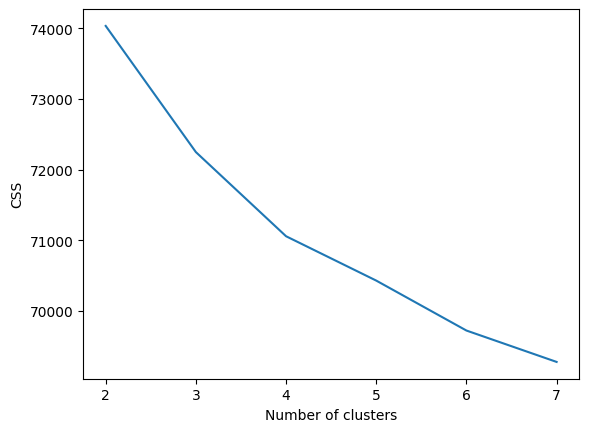

In [13]:
#plot showing the within-cluster sum of squares (CSS) for different numbers of clusters
import matplotlib.pyplot as plt
plt.plot(range(2, 8), css)
plt.xlabel('Number of clusters')
plt.ylabel('CSS') 
plt.show()

In [14]:
num_clusters = 3  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, max_iter=300, n_init=20, random_state=42)
kmeans.fit(cv_matrix)

# Assigning Parks to Clusters
park_cluster_mapping = {}  # Dictionary to store park to cluster mapping

for park in df['Park'].unique():
    park_reviews = df[df['Park'] == park]['Review']
    park_reviews_vector = cv.transform(park_reviews)
    park_cluster = kmeans.predict(park_reviews_vector)[0]
    park_cluster_mapping[park] = park_cluster

# Displaying Park to Cluster Mapping
for park, cluster in park_cluster_mapping.items():
    print(f"{park}: Cluster {cluster + 1}")

Central Park: Cluster 3
Eco Tourism Park: Cluster 2
Elliot Park: Cluster 2
Maidan: Cluster 2
Millenium Park: Cluster 2
Nature Park: Cluster 3
Nicco Park: Cluster 2
Princep Ghat Park: Cluster 1
Rabindra Sarobar: Cluster 2
Science City: Cluster 2


In [15]:
feature_names = cv.get_feature_names_out()  # Retrieves the feature names from CountVectorizer object cv
topn_features = 15  # Number of top features to be considered for each cluster
ordered_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # Orders the centroids by their values in descending order. 

# Get key features for each cluster
for cluster_num in range(num_clusters):
    key_features = [feature_names[index]  # Extract the top topn_features features for the current cluster
                    for index in ordered_centroids[cluster_num, :topn_features]]  # Retrieve the feature names based on the indices of the most important features for each cluster
    parks_in_cluster = [park for park, cluster in park_cluster_mapping.items() if cluster == cluster_num]  # Retrieve parks belonging to the current cluster
    print(f'CLUSTER #{cluster_num + 1}')  # Print the cluster number
    print('Key Features:', key_features)  # Print the key features for the cluster
    print('Parks in Cluster:', parks_in_cluster)  # Print parks belonging to the cluster
    print('-' * 80)  # Print a separator line to visually distinguish between clusters

CLUSTER #1
Key Features: ['place', 'visit', 'kolkata', 'good', 'time', 'also', 'nice', 'one', 'science', 'city', 'family', 'enjoy', 'park', 'well', 'evening']
Parks in Cluster: ['Princep Ghat Park']
--------------------------------------------------------------------------------
CLUSTER #2
Key Features: ['place', 'good', 'visit', 'park', 'kolkata', 'one', 'time', 'science', 'city', 'also', 'river', 'nice', 'evening', 'enjoy', 'well']
Parks in Cluster: ['Eco Tourism Park', 'Elliot Park', 'Maidan', 'Millenium Park', 'Nicco Park', 'Rabindra Sarobar', 'Science City']
--------------------------------------------------------------------------------
CLUSTER #3
Key Features: ['park', 'place', 'also', 'kolkata', 'one', 'rides', 'visit', 'good', 'eco', 'time', 'water', 'lake', 'well', 'many', 'family']
Parks in Cluster: ['Central Park', 'Nature Park']
--------------------------------------------------------------------------------


Cluster 1: Family and Leisure

Key Features: place, visit, good, time, nice, family, enjoy, park, evening
Parks in Cluster: Princep Ghat Park
Description: This cluster seems to focus on parks suitable for family outings and leisure activities. It emphasizes features such as enjoyable visits, good times, and pleasant evenings.

Cluster 2: City Parks and Attractions Cluster

Key Features: place, good, visit, park, science, city, river, nice, evening
Parks in Cluster: Eco Tourism Park, Elliot Park, Maidan, Millenium Park, Nicco Park, Rabindra Sarobar, Science City
Description: This cluster comprises parks located within or near the city (Kolkata) and offers diverse attractions such as parks, rivers, and science-related activities.

Cluster 3: Natural and Eco-Friendly Cluster:

Key Features: park, place, eco, water, lake, rides, family
Parks in Cluster: Central Park, Nature Park
Description: This cluster represents parks with a focus on natural elements and eco-friendly attractions. It highlights features such as eco-friendly initiatives, water bodies, and family-oriented activities.

In [16]:
# Feature Engineering
X = df['Review']
y = df['Ratings'].apply(lambda x: 1 if x >= 4 else 0)  # Convert ratings to binary labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #stratified sampling

# Vectorize text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [17]:
# Check the class distribution in the original dataset
original_class_distribution = y.value_counts(normalize=True)
print("Original Class Distribution:")
print(original_class_distribution)

Original Class Distribution:
1    0.927845
0    0.072155
Name: Ratings, dtype: float64


In [18]:
# Check the class distribution in the training set
train_class_distribution = y_train.value_counts(normalize=True)
print("\nTraining Set Class Distribution:")
print(train_class_distribution)


Training Set Class Distribution:
1    0.927911
0    0.072089
Name: Ratings, dtype: float64


In [19]:
# Check the class distribution in the testing set
test_class_distribution = y_test.value_counts(normalize=True)
print("\nTesting Set Class Distribution:")
print(test_class_distribution)


Testing Set Class Distribution:
1    0.927581
0    0.072419
Name: Ratings, dtype: float64


# Classification

In [20]:
# Initialize Logistic Regression with TF-IDF vectorized data

# Train classification model
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = model.predict(X_test_vectorized)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

Accuracy: 0.9137134052388289
Precision: 0.9305993690851735
Recall: 0.9800664451827242
F1-score: 0.9546925566343042
ROC-AUC: 0.5219481162083834


C:\Users\aryan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Initialize Multinomial Naive Bayes classifier with TF-IDF vectorized data
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectorized, y_train)

# Make predictions
y_predict = nb_tfidf.predict(X_test_vectorized)
y_prob = nb_tfidf.predict_proba(X_test_vectorized)[:, 1]

# Evaluate model
print(classification_report(y_test, y_predict))
print('Confusion Matrix:', confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.93      1.00      0.96       602

    accuracy                           0.93       649
   macro avg       0.46      0.50      0.48       649
weighted avg       0.86      0.93      0.89       649

Confusion Matrix: [[  0  47]
 [  0 602]]
AUC: 0.5602777974128791


C:\Users\aryan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aryan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aryan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Considering the nature of the problem and the importance of correctly identifying positive sentiment, precision and recall might be more critical evaluation metrics. However, it's also important to consider the balance between precision and recall, which is captured by the F1-score. Therefore, a combination of precision, recall, and F1-score would provide a comprehensive assessment of the model's performance. Additionally, ROC-AUC could also provide valuable insights into the model's ability to discriminate between positive and negative sentiment. Ultimately, the choice of evaluation metric should align with the project's objectives and the relative importance of minimizing false positives versus false negatives.

The most suitable evaluation metric for this classification model would be F1-score.

Justification for choosing F1-score:

F1-score: The F1-score provides a balance between precision and recall, making it suitable for imbalanced datasets. It considers both false positives and false negatives, making it a robust metric for binary classification tasks like sentiment analysis.

Importance of balanced performance: In sentiment analysis, it's equally important to correctly identify positive sentiment (high recall) while minimizing misclassification errors (high precision). The F1-score strikes a balance between these two objectives, providing a comprehensive measure of the model's performance.

Robustness to class imbalance: Since sentiment analysis datasets often have imbalanced classes (e.g., more negative reviews than positive), the F1-score accounts for the uneven distribution of classes and evaluates the model's performance effectively.

Interpretability: The F1-score is easy to interpret, as it represents the harmonic mean of precision and recall. It provides a single value that summarizes the model's ability to classify both positive and negative sentiment.

Therefore, for the classification models trained on TF-IDF vectorized data in this sentiment analysis task, the F1-score would be the preferred evaluation metric to assess the overall performance of the models accurately.

# Topic Modelling

No, the fact that a person gives a lower rating does not necessarily mean that they commented something "wrong" about the park. Ratings are subjective and can be influenced by various factors such as personal preferences, expectations, experiences, and even mood at the time of the visit. 

A lower rating might indicate that the person had a less enjoyable experience compared to someone who gave a higher rating, but it doesn't necessarily mean their comments are inaccurate or "wrong". It's essential to consider the context of the review and the reasons behind the rating given by the individual.

In [22]:
# Define a function to categorize ratings as negative or positive
def categorize_rating(rating):
    if rating <= 3:
        return 'negative'
    else:
        return 'positive'

# Apply the function to create a new column 'Sentiment'
df['Sentiment'] = df['Ratings'].apply(categorize_rating)

In [23]:
df

,Date,Ratings,Review,Park,Sentiment
0,Aug 2019,4.0,Best for photo shoots and love the rose garden...,Central Park,positive
1,Dec 2019,5.0,Another attraction in the Central Park is its ...,Central Park,positive
2,Apr 2019,4.0,There is enough greenery to bring people and a...,Central Park,positive
3,Jan 2019,3.0,"If you are in Salt Lake City of Kolkata, you m...",Central Park,negative
4,Feb 2019,3.0,Not a good place to just hang out with friends...,Central Park,negative
...,...,...,...,...,...
3238,Jul 2011,4.0,Really Great Park Having Full Of Technological...,Science City,positive
3239,Nov 2011,5.0,A friend and I spent a morning here thanks to ...,Science City,positive
3240,Aug 2011,4.0,If you are in the mood for a picnic with your ...,Science City,positive
3241,Jan 2011,5.0,Science city is one of my favourite places in ...,Science City,positive


In [24]:
# Filter the DataFrame to select only reviews with 'positive' sentiment
positive_reviews_df = df[df['Sentiment'] == 'positive'][['Review']]

In [25]:
# Display the new DataFrame
positive_reviews_df

,Review
0,Best for photo shoots and love the rose garden...
1,Another attraction in the Central Park is its ...
2,There is enough greenery to bring people and a...
5,This is a very good place to enjoy some times ...
8,Waking here in the evening time was good for h...
...,...
3238,Really Great Park Having Full Of Technological...
3239,A friend and I spent a morning here thanks to ...
3240,If you are in the mood for a picnic with your ...
3241,Science city is one of my favourite places in ...


In [26]:
# Filter the DataFrame to select only reviews with 'positive' sentiment
negative_reviews_df = df[df['Sentiment'] == 'negative'][['Review']]

In [27]:
# Display the new DataFrame
negative_reviews_df

,Review
3,"If you are in Salt Lake City of Kolkata, you m..."
4,Not a good place to just hang out with friends...
6,Greenery in the city of joy...a wonderful plac...
7,You can really enjoy a walkOf around 3 KM insi...
13,A bit of green amidst the buildings of salt la...
...,...
2535,"The Lake, as it is known to Kolkatans, this is..."
2544,"This is one of the best places to walk , breat..."
2551,The area contains a football stadium and the b...
2560,I visited this attraction with the expectation...


In [28]:
# Vectorizing the text data using TF-IDF
vectorizer_tf = TfidfVectorizer(max_df=0.75, min_df=50, max_features=6000)
tf_vectors = vectorizer_tf.fit_transform(negative_reviews_df['Review'])

# Initializing LDA model
lda = LatentDirichletAllocation(n_components=6, max_iter=5, learning_method='online', learning_offset=50, random_state=111)

# Fitting LDA model to the TF-IDF vectors
W = lda.fit_transform(tf_vectors)

# Collecting top words for each topic
num_words = 15
vocab = np.array(vectorizer_tf.get_feature_names_out())
top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = [top_words(t) for t in lda.components_]
topics = [' '.join(t) for t in topic_words]

In [29]:
#topics extracted from data
topics

['you are for to can of is park there place and this time in good',
 'park with it can is for you there kolkata in of and visit very place',
 'and to of is for in place park it this with good can kolkata you',
 'in with you for of is there good place it to visit and park this',
 'very is and visit are good park it in for to of there this time',
 'it time can of is to park place and with there you for in kolkata']

In [30]:
# Identifying dominant topic for each document
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(negative_reviews_df))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

# Checking the dominant topics for documents
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.04,0.04,0.78,0.04,0.04,0.04,2
Doc1,0.05,0.05,0.75,0.05,0.05,0.05,2
Doc2,0.05,0.05,0.74,0.05,0.05,0.05,2
Doc3,0.04,0.04,0.79,0.04,0.04,0.04,2
Doc4,0.05,0.05,0.75,0.05,0.05,0.05,2


Dominant Topic (Topic2):

The dominant topic across all documents is Topic2, as indicated by the highest probabilities in the dominant_topic column.
This suggests that the documents share a common theme or subject matter primarily related to Topic2.

Distribution of Topics:

Across all documents, Topic2 consistently has the highest probability, indicating its prevalence in the dataset.
Topics 0, 1, 3, 4, and 5 have lower probabilities, suggesting they might be secondary themes or less significant compared to Topic2.

Consistency:

Similar to the previous dataset, the probabilities within each document are relatively consistent, with Topic2 consistently having the highest probability and the other topics having lower, but similar probabilities.
This consistency indicates that each document primarily focuses on Topic2, with some degree of similarity in content across the dataset.

In [31]:
# Vectorizing the text data using TF-IDF
vectorizer_tf = TfidfVectorizer(max_df=0.75, min_df=50, max_features=6000)
tf_vectors = vectorizer_tf.fit_transform(positive_reviews_df['Review'])

# Initializing LDA model
lda = LatentDirichletAllocation(n_components=6, max_iter=5, learning_method='online', learning_offset=50, random_state=111)

# Fitting LDA model to the TF-IDF vectors
W = lda.fit_transform(tf_vectors)

# Collecting top words for each topic
num_words = 15
vocab = np.array(vectorizer_tf.get_feature_names_out())
top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = [top_words(t) for t in lda.components_]
topics = [' '.join(t) for t in topic_words]

In [32]:
#topics extracted from data
topics

['river ghat of bridge and is place to view in on ganges evening hooghly princep',
 'and is to of place for in it park you science with this are there',
 'place to spend with and is very this nice time friends good your you in',
 'scientific is shows park to nature in for and but place experience main of very',
 'of india and park wonders in we prinsep for garden excellent metro place so it',
 'of popular is park for children are can here on its this and in eco']

Both the positive and negative class topics are related to parks, places to visit, and attractions in Kolkata or India. However, the positive class examples seem to emphasize positive aspects such as enjoyment, beauty, and good experiences, while the negative class examples highlight more neutral or negative aspects such as scientific features, popularity, and being a place for children.

In [33]:
# Identifying dominant topic for each document
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(positive_reviews_df))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

# Checking the dominant topics for documents
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.03,0.87,0.03,0.03,0.03,0.03,1
Doc1,0.04,0.80,0.04,0.04,0.04,0.04,1
Doc2,0.04,0.81,0.04,0.04,0.04,0.04,1
Doc3,0.04,0.81,0.04,0.04,0.04,0.04,1
Doc4,0.04,0.81,0.04,0.04,0.04,0.04,1


Dominant Topic (Topic1):

The dominant topic across all documents is Topic1, as indicated by the highest probabilities in the dominant_topic column.
This suggests that the documents share a common theme or subject matter primarily related to Topic1.

Distribution of Topics:

Across all documents, Topic1 consistently has the highest probability, indicating its prevalence in the dataset.
Topics 0, 2, 3, 4, and 5 have lower probabilities, suggesting they might be secondary themes or less significant compared to Topic1.

Consistency:

The probabilities within each document are relatively consistent, with Topic1 consistently having the highest probability and the other topics having lower, but similar probabilities.
This suggests that each document primarily focuses on Topic1, with some degree of similarity in content across the dataset.

# Suggestions to the Kolkata Municipal Corporation 

**Enhance Family-Friendly Amenities**: Since family-friendly features were highlighted in one of the clusters, focusing on amenities suitable for families, such as playgrounds, picnic areas, and recreational facilities, could attract more visitors.

**Invest in City Park Attractions**: City parks and attractions cluster indicates the popularity of urban parks. Enhancing infrastructure, adding recreational facilities, and organizing events could further elevate the appeal of these parks.

**Promote Eco-Friendly Initiatives**: Given the emphasis on eco-friendly features in Cluster 3, implementing sustainable practices, preserving green spaces, and offering nature-based activities could attract environmentally-conscious visitors.

**Addressing Negative Feedback**:
- Based on the negative feedback, it's crucial for the Kolkata Municipal Corporation to address issues related to cleanliness, maintenance, and safety promptly.
- Regular maintenance schedules should be implemented to ensure cleanliness and upkeep of the parks.
Safety measures such as adequate lighting, security patrols, and proper signage should be prioritized.

**Enhancing Park Amenities**:
   - Improving amenities such as seating arrangements, recreational facilities, restroom facilities, and accessibility features can enhance visitor experience and satisfaction.
   - Adding features like playgrounds, walking paths, fitness equipment, and green spaces can attract more visitors and improve overall park usage.

**Community Engagement**:
   - Engaging with the local community to gather feedback and suggestions for park improvement initiatives can be valuable.
   - Conducting surveys, hosting community meetings, or establishing feedback mechanisms can help understand community preferences and priorities.

**Promoting Positive Features**:
   - Leveraging positive aspects highlighted in the positive reviews, such as scenic beauty, well-maintained areas, and available amenities, can be part of marketing and promotional efforts to attract more visitors.

**Continuous Monitoring and Evaluation**:
   - Implementing a system for ongoing monitoring and evaluation of park conditions, visitor feedback, and usage patterns can help in identifying areas for improvement and tracking progress over time.
   - Regular audits and assessments can ensure that the parks meet established standards and cater to the needs of the community effectively.

**Investing in Sustainable Practices**:
   - Emphasizing sustainability initiatives such as green infrastructure, water conservation, waste management, and biodiversity conservation can contribute to the long-term viability and attractiveness of the parks.

By addressing the identified issues and leveraging positive aspects, the Kolkata Municipal Corporation can enhance the overall quality and attractiveness of its parks, providing residents and visitors with enjoyable and memorable experiences.